### This notebook aims to get a deeper understanding of the dataset domain

In [312]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import colors as mcolors

### Demographics exploration
At first, we will be analyzing the population of the anime community

Age extraction

In [313]:
users = pd.read_csv('Data/userlist_filt.csv')
users['birth_date'] = pd.to_datetime(users['birth_date'],errors='coerce')
users['age'] = ((pd.to_datetime('2018-01-01') - users['birth_date'])/pd.Timedelta(days=365.25)).dropna().round()
users = users[users['age'] > 12] # While there is no minimum age, its unlikely that kids will have their own anime lists
ages = users.groupby('age').size().reset_index(name='count')
ages_expanded = ages.loc[ages.index.repeat(ages['count'])]['age']
ages['age'] = ages['age'].astype('int64')

Country mapping

In [314]:
cities = pd.read_csv('Data/tableCities.csv', usecols=[1,5,6],header=None,names=['City','Country','Country_iso'])

In [315]:
city_to_country = dict(zip(cities['City'].str.lower(), cities['Country'].values.tolist()))
country_abbr_to_country = dict(zip(cities['Country_iso'].str.upper(), cities['Country']))
def infer_country(location, city_to_country, country_abbr_to_country):
    location = location.lower().strip()
    
    # Check for country name in the location string
    for country in country_abbr_to_country.values():
        if country.lower() in location:
            return country
    
    # Check for country abbreviation
    if location.upper() in country_abbr_to_country:
        return country_abbr_to_country[location.upper()]
    
     # Check for exact city match
    if location in city_to_country:
        return city_to_country[location]
    
    # If no match found
    return 'Unknown'

In [316]:
users['country'] = users['location'].apply(lambda loc: infer_country(loc, city_to_country, country_abbr_to_country))
users = users[users['country'] != 'Unknown']

In [317]:
countries = users.groupby('country').size().reset_index(name='count')
countries.rename(columns={'country': 'SOVEREIGNT', 'count': 'User_Count'}, inplace=True)

Plotting age distribution and user counts by country
###### this code looks awful but that's normal when working with pyplot

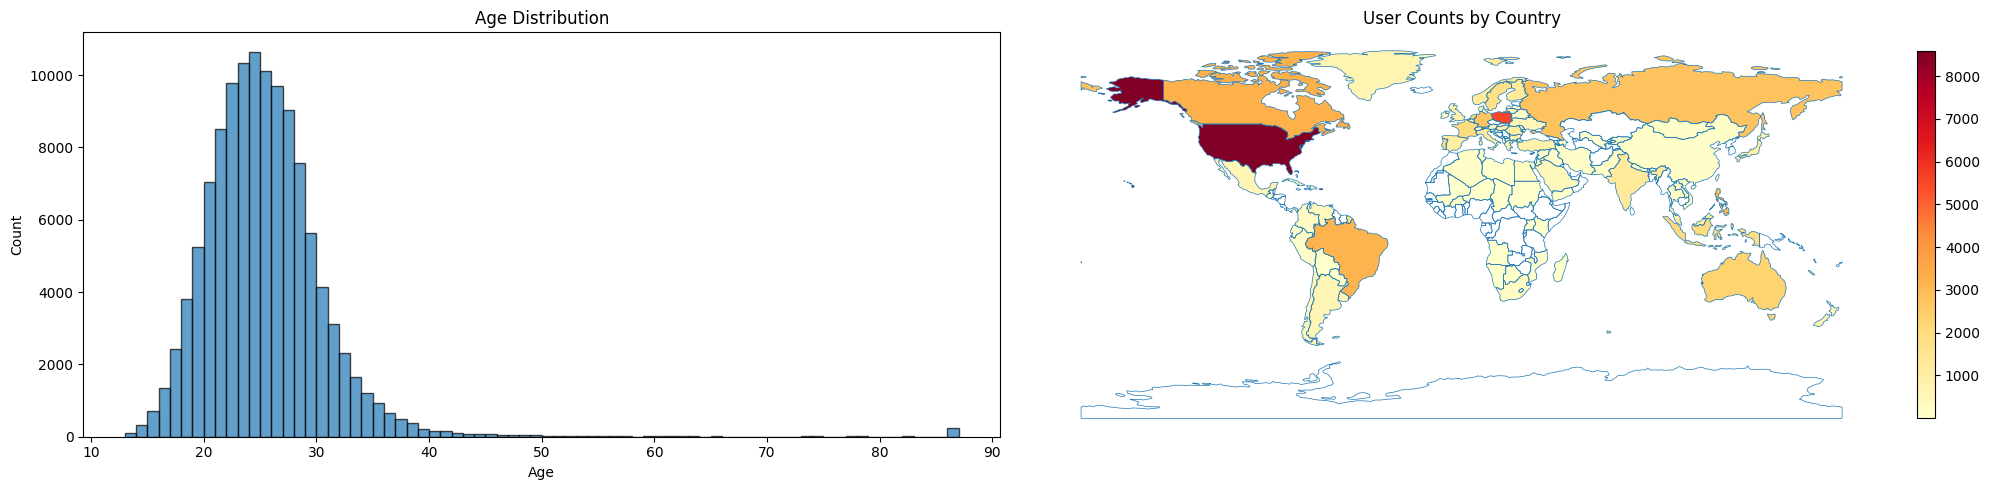

In [318]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.hist(ages_expanded, bins=range(min(ages['age']), max(ages['age'])), edgecolor='black', alpha=0.7)
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

world = gpd.read_file('Data/ne_110m_admin_0_sovereignty/ne_110m_admin_0_sovereignty.shp')
world = world.merge(countries, how='left', on='SOVEREIGNT')
world.boundary.plot(ax=ax2, linewidth=0.5)
choropleth = world.plot(column='User_Count', ax=ax2, legend=False, cmap='YlOrRd')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=mcolors.Normalize(vmin=countries['User_Count'].min(), vmax=countries['User_Count'].max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', fraction=0.02, pad=0.04)
ax2.axis('off')
ax2.set_title('User Counts by Country')
plt.tight_layout()
plt.show()